In [14]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'tss_ccres_overlap',
        root = '..'
    )

In [15]:
import numpy as np
import pandas as pd
import pyranges as pr
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from lapa.result import LapaTssResult

In [17]:
lapa = LapaTssResult(snakemake.input['lapa_dir'])

In [21]:
df_tss = lapa.read_clusters(filter_intergenic=False)

In [20]:
snakemake.input['lapa_dir']

'/data/homezvol2/mcelik/Projects/rnawg/data/results/lapa/tss'

In [22]:
gr_cres_all = pr.read_bed(snakemake.input['ccres_all'])

gr_cres_promoter = pr.read_bed(snakemake.input['ccres_promoters'])
gr_cres_proximal = pr.read_bed(snakemake.input['ccres_proximal_enhancers'])
gr_cres_distal = pr.read_bed(snakemake.input['ccres_distal_enhancers'])

#gr_cres_CA_H3K4me3 = pr.read_bed(snakemake.input['ccres_CA_H3K4me3'])
#gr_cres_CA_CTCF = pr.read_bed(snakemake.input['ccres_CA_CTCF'])
#gr_cres_CA_TF = pr.read_bed(snakemake.input['ccres_CA_TF'])
#gr_cres_CA = pr.read_bed(snakemake.input['ccres_CA'])
#gr_cres_TF = pr.read_bed(snakemake.input['ccres_TF'])

In [23]:
def nearest_cCREs(gr, distance=100):    
    ccres = [
        ('promoter', gr_cres_promoter),
        ('proximal enhancer', gr_cres_proximal),
        ('distal enhancer', gr_cres_distal),
        ('other cCREs', gr_cres_all)
    ]
    overlap = dict()
    
    _gr = gr
    
    for label, gr_ccres in ccres:
        _gr = _gr.nearest(gr_ccres)
        overlap[label] = _gr[_gr.Distance <= distance]
        _gr = _gr[_gr.Distance > distance]
        _gr = _gr.drop(like='_b').drop(like='Distance')

    return overlap

In [24]:
tpm_filters = {
    '0-1': (0, 1),
    '1-5': (1, 5),
    '5-10': (5, 10),
    '10-25': (10, 25),
    '25-50': (25, 50),
    '50+': (50, np.inf),
}

In [25]:
df = list()

for label, (lower, upper) in tqdm(tpm_filters.items()):
    _gr = pr.PyRanges(df_tss[(upper > df_tss['tpm']) & (df_tss['tpm'] >= lower)])

    for ccres_type, _gr_cre in nearest_cCREs(_gr).items():    
        df.append({
            'TPM': label,
            '# of TSS': len(_gr_cre),
            'cCREs': ccres_type,
            'total': len(_gr),
            'percentage': len(_gr_cre) / len(_gr)
        })

df = pd.DataFrame(df)

  0%|          | 0/6 [00:00<?, ?it/s]

In [26]:
df.to_csv(snakemake.output['table'], index=False)
df

,TPM,# of TSS,cCREs,total,percentage
0,0-1,10012,promoter,69649,0.143749
1,0-1,7057,proximal enhancer,69649,0.101322
2,0-1,22267,distal enhancer,69649,0.319703
3,0-1,3572,other cCREs,69649,0.051286
4,1-5,5980,promoter,16309,0.366669
5,1-5,1593,proximal enhancer,16309,0.097676
6,1-5,4038,distal enhancer,16309,0.247593
7,1-5,582,other cCREs,16309,0.035686
8,5-10,2609,promoter,4134,0.631108
9,5-10,315,proximal enhancer,4134,0.076197


In [27]:
colors = ["#5a5a83", "#b1615c", "#d88782", "#edd7d9"]

In [28]:
def plot_percentage_candy_bar(data, x, y, hue=None, label=None, colors=None, hue_order=None):
    '''
    Plots percentage candy bar plot
    
    Args:
        data: dataframe
        x: x-axis
        y: y-axis
        hue: bars stack together
        label: text top of each bar
        color: color of hue
        hue_order: order of hue in bars
    '''
    x_categories = data[x].unique()

    ax = sns.barplot(
        y=[1] * len(x_categories),
        x=x_categories, 
        edgecolor='black', color='white', dodge=True)

    _data = data.pivot(index=x, columns=hue, values=y).loc[x_categories]
    
    if hue_order:
        _data = _data[hue_order]

    ax =  _data.plot(kind='bar', stacked=True, ax = ax, color=colors, width=0.773)

    if label:
        ax.bar_label(ax.containers[0], 
                     labels=data.set_index(x).loc[x_categories][label].unique())
    plt.ylim((0, 1))
    sns.despine()
    
    return ax

In [29]:
ccres_types = ['other cCREs', 'distal enhancer', 'proximal enhancer', 'promoter'][::-1]

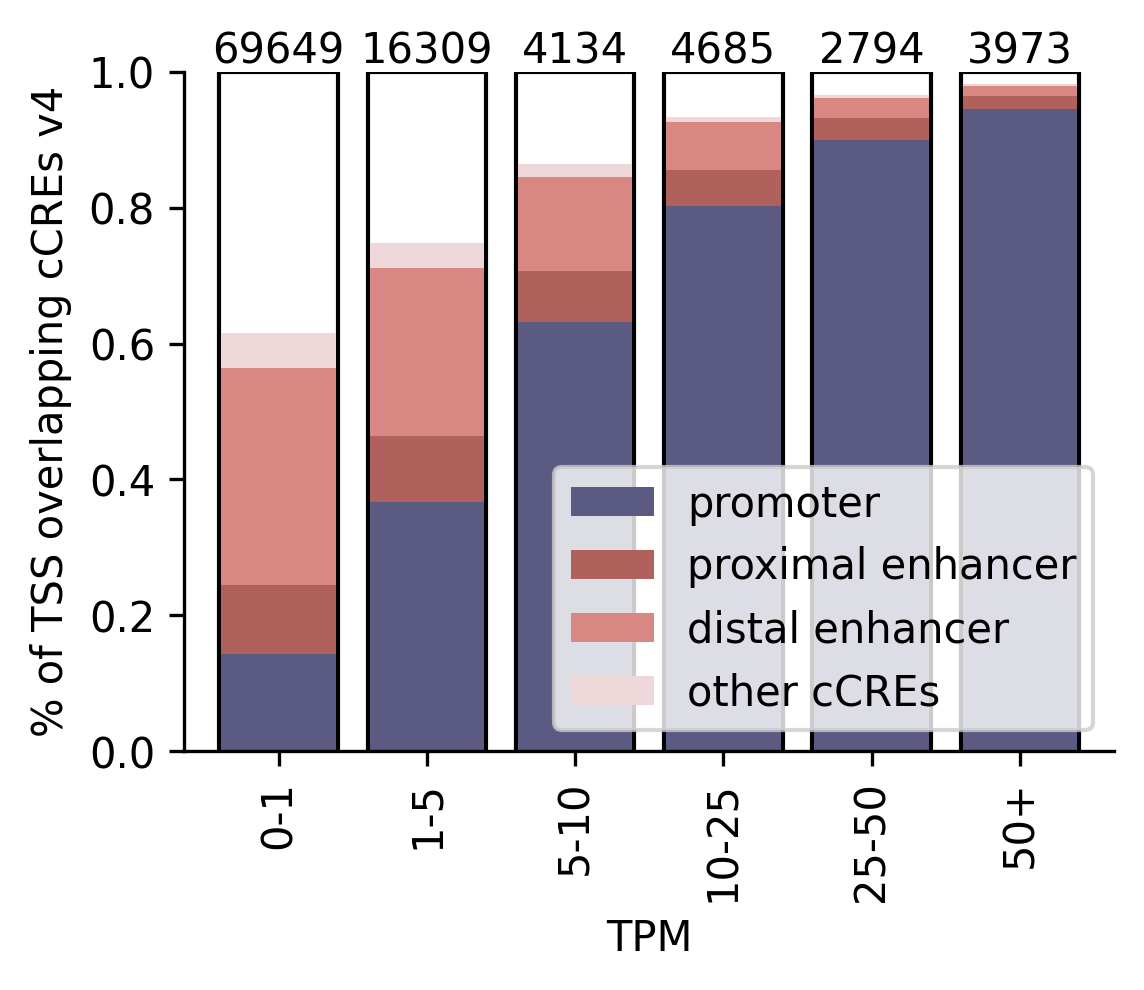

In [30]:
plt.figure(figsize=(4, 3), dpi=300)

plot_percentage_candy_bar(df, 'TPM', 'percentage', 'cCREs', 'total', colors=colors, hue_order=ccres_types)
plt.legend(loc='lower right')
plt.xlabel('TPM')
plt.ylabel('% of TSS overlapping cCREs v4')

plt.savefig(snakemake.output['fig'], bbox_inches = "tight")